# TransLeish _In Vitro_ study analysis

We want to extract cell line barcodes from sequencing samples, count their unique occurrances and infer the cell line fitnesses.

We need to load a set of libraries for this:
 * `matplotlib`: a plotting library
 * `numpy`: python extension to work with large numerical arrays
 * `pandas`: data analysis tool to work with large spreadsheet-like data sets
 * `scipy`: library that includes many scientific data analysis methods (we use it here for the statistics)
 * `tqdm`: tool to display a progress bar

We are also using a few python internal libraries:
 * `re`: library to work with regular expressions (mainly used for the analysis of text)
 * `pathlib`: library to handle paths to directories and files
 * `json`: library to load and save structured data
 * `urllib.request`: library to load data from URLs

Finally, we use the internally-developed library `LeishFASTQ` to extract the unique barcodes from our sequenceing FASTQ files.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
idx = pd.IndexSlice
from scipy.stats import mannwhitneyu

from tqdm.auto import tqdm

import re
import pathlib
import json
from urllib.request import urlopen, urlretrieve

from LeishFASTQ.leishfastq import process_fastq_files


First, let us find the list of samples and URLs to the FASTQ files from the ENA. This essentially queries the ENA for the TransLeish project accession number and extracts all samples that start with "TL1". We then use this to construct a list of samples with the corresponding forward and reverse read FASTQ file URLs.

In [9]:
with urlopen('https://www.ebi.ac.uk/ena/portal/api/search?result=read_run&query=study_accession%3D%22PRJEB76744%22%20AND%20sample_title%3D%22TL1_*%22&fields=fastq_ftp%2Csample_title&format=json') as f:
    content = f.read()

runs = (
    pd.DataFrame(json.loads(content.decode('ascii')))
    .set_index('sample_title')
    .fastq_ftp.str.split(';', expand=True)
    .rename(columns=lambda x: str(x + 1))
    .rename_axis('direction', axis=1)
    .stack()
)
runs

sample_title  direction
TL1_OB_0h     1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/063/ERR132...
              2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/063/ERR132...
TL1_OC_0h     1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/065/ERR132...
              2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/065/ERR132...
TL1_OC_24h    1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/066/ERR132...
              2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/066/ERR132...
TL1_OA_0h     1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/061/ERR132...
              2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/061/ERR132...
TL1_OA_24h    1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/062/ERR132...
              2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/062/ERR132...
TL1_OB_24h    1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/064/ERR132...
              2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/064/ERR132...
dtype: object

Next, we download the FASTQ files from ENA (unless the files are already present from a previous run, in which case the downloading is skipped).

In [6]:
directory = pathlib.Path('.')
for (sample, direction), url in tqdm(runs.items(), total=runs.shape[0]):
    filename = f"{sample}_R{direction}_.fastq.gz"
    if not (directory / filename).exists():
        urlretrieve("http://" + url, filename=filename)

  0%|          | 0/12 [00:00<?, ?it/s]

We also need to load the database that maps the 17nt barcode sequences to their corresponding IDs.

In [7]:
barcode_database = pd.read_csv('barcode_database.csv').set_index('barcode_sequence')

Now we use the function `process_fastq_files` from the `LeishFASTQ` library to find all barcode sequences in the FASTQ files and compare them to the known sequences in `barcode_database`. This is done by allowing up to two nucleotide substitutions in the flanking sequences, and up to a single substitution in the barcode sequence itself (when comparing to the known barcodes). Please ignore the warning about allowing more than one substition - it safely reduces the number of substitutions to one only in the barcode sequences.

In [8]:
raw_read_counts = process_fastq_files(
    list(pathlib.Path('.').glob('TL1_*.fastq.gz')),
    allow_substitutions=2,
    known_sequences=list(barcode_database.index),
    progress_wrap=lambda *a, **kw: tqdm(*a, desc="Finding barcodes", **kw)
)

Finding barcodes:   0%|          | 0/12 [00:00<?, ?it/s]

We next create a long list of barcode sequences and their read counts in each sample. Please note that we simply add the read counts from the forward and reverse reads. Invalid reads that do not have a valid barcode in them are identified by a blank barcode sequence.

In [10]:
fname_re = re.compile('TL1_(?P<sample>O[ABC])_(?P<time>0h|24h)_R(?P<fwdrev>[12])_*')

read_counts = (
    pd.concat(
        [
            pd.DataFrame(
                [
                    {'barcode_sequence': seq, 'count': v['count'], 'mismatched': v['mismatched']}
                    for seq, v in counts.items()
                ]
            )
            .assign(**fname_re.match(fname).groupdict())
            .set_index(['sample', 'time', 'fwdrev', 'barcode_sequence'])
            for fname, counts in raw_read_counts.items()
        ]
    )
    .sort_index()
    .groupby(level=['sample', 'time', 'barcode_sequence'], dropna=False)
    .sum()
    .loc[:, ['count']]
)
read_counts

count
sample time barcode_sequence        
OA     0h                      54676
            AAAAAAAGAAAGAAAGG      1
            AAAAAACGAAAGAGATA      1
            AAAAAAGAAGGAAAAGA      1
            AAAAAAGGAACCAGAAC      1
...                              ...
OC     24h  TTTTTCGTTCAAGTCTC      1
            TTTTTCTGCCTGGCGAT      1
            TTTTTGAGGTCTGTAGC      1
            TTTTTGGTGACTGTCGC      1
            TTTTTTTACCCGAGTGT      1

[117385 rows x 1 columns]

Now we need to load the list of cell line barcode IDs that actually were put through the experiment.

In [12]:
membership = pd.read_csv('invitro_membership.csv').assign(inpool=1).set_index('barcode').inpool

We next lay out the data frame into a wide format with time points and samples, and include the membership "inpool" information above.

In [13]:
timepoints = (
    read_counts
    .unstack(['time', 'sample'], fill_value=0)
    .join(barcode_database.barcode.rename(('barcode', '', ''), ))
    .join(
        membership.rename(('inpool', '', '')),
        on='barcode',
        how='outer',
    )
    .rename_axis('barcode_sequence')
)
timepoints.loc[:, 'inpool'] = timepoints.loc[:, 'inpool'] == 1.0
timepoints.loc[timepoints.loc[:, 'barcode'].isna(), 'barcode'] = ''
timepoints = timepoints.fillna(0.0).set_index(['barcode', 'inpool'], append=True)
timepoints = timepoints.astype(int).loc[:, 'count']
timepoints = timepoints.rename_axis(columns=['time', 'sample'])
filtered_timepoints = timepoints.loc[(timepoints > 0).any(axis=1)].sort_index(level=['inpool', 'barcode', 'barcode_sequence'], ascending=False).sort_index(axis=1)
filtered_timepoints

time                                 0h                  24h              
sample                               OA     OB     OC     OA     OB     OC
barcode_sequence  barcode inpool                                          
AGTTGGCGGGCTGTTTT B999    True     2533   2153   2751   4170   3485   3647
AGCCTCACGCGGAATCT B9988   True     2038   1783   2209   2106   1800   2093
GTCCGTATCTTACTTCA B9927   True     2716   2709   2836   3285   4222   3504
GACTGGTTTGGAACTGG B9918   True     1127   1062   1234   1953   1630   1803
CGGGGGAAGCACAGTTA B9827   True      619    513    735    968    759    828
...                                 ...    ...    ...    ...    ...    ...
AAAAAAAGGAGACGAGA         False       0      0      1      0      0      0
AAAAAAAGAATGAGGGA         False       0      0      0      0      0      1
AAAAAAAGAAAGAAAGG         False       1      0      0      0      0      0
AAAAAAAAAGCGAAAGG         False       0      1      0      0      0      0
                          False   54676  50559  62264  34211  31103  32579

[100887 rows x 6 columns]

We provide a summary, as in how many reads were from expected barcodes (in the pool), how many were foreign to the pool, how many reads were invalid, etc.

In [14]:
def count(g):
    return (g>0).sum()
summary = timepoints.groupby([timepoints.index.get_level_values('barcode_sequence') != '', timepoints.index.get_level_values('barcode') != '', timepoints.index.get_level_values('inpool')]).agg(['sum', count]).sort_index(axis=1).rename({'count': 'unique_barcodes', 'sum': 'total_counts'}, axis=1).reorder_levels([2, 0, 1], axis=1)
summary = summary[summary.sum(axis=1) > 0]
summary.sort_index(axis=1, inplace=True)
summary.index = pd.Series(['invalid_reads', 'unknown_sequences', 'foreign_barcodes', 'pool_members'])#.rename('category')
summary

total_counts                                          \
time                        0h                     24h                   
sample                      OA      OB      OC      OA      OB      OC   
invalid_reads            54676   50559   62264   34211   31103   32579   
unknown_sequences        20259   17406   18549   21460   21222   23848   
foreign_barcodes          2334    1146    1539    1142    1017     972   
pool_members            424685  394725  476906  594753  539008  562535   

                  unique_barcodes                                     
time                           0h                  24h                
sample                         OA     OB     OC     OA     OB     OC  
invalid_reads                   1      1      1      1      1      1  
unknown_sequences           19106  16410  17365  19859  19832  22269  
foreign_barcodes              198    156    181    151    152    147  
pool_members                  259    259    260    258    259    258

The graph below shows the number of read counts in each sample, split up in the following categories:
* Pool members - these are read counts from expected cell lines
* Foreign barcodes - these are read counts from cell lines for which the barcode sequence is known, but which weren't present in the experiment. If we had a lot of these foreign barcodes, we clearly had an issue during e.g. sample preparation.
* Unknown sequences - these reads have valid flanking sequences and a barcode sequence of the correct length, but the barcode sequence itself is not associated with any known cell line.
* Invalid reads - these are reads that have missing or mangled flanking sequences or a barcode sequence of an incorrect length.

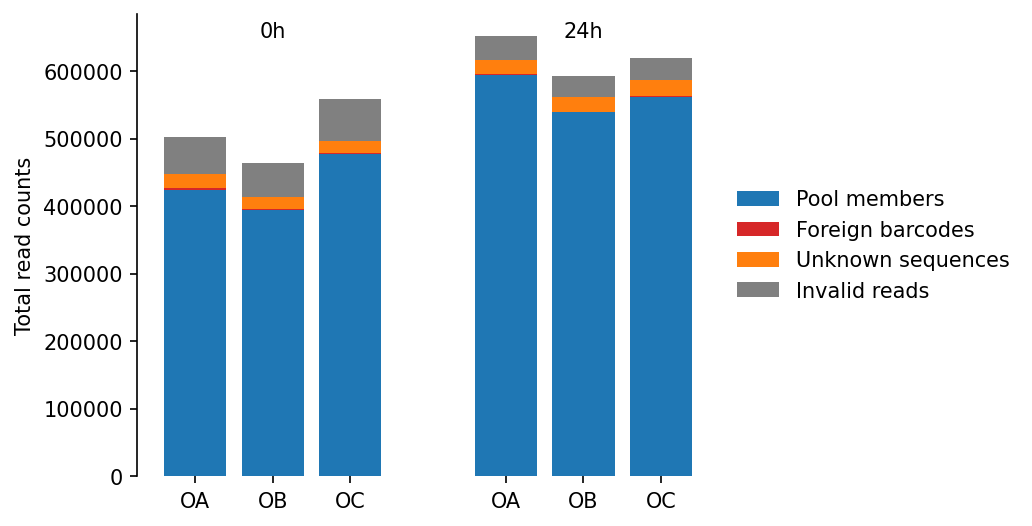

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150)

quantity = 'total_counts'

x = [0, 1, 2, 4, 5, 6]
ax.bar(x, summary.loc['pool_members', quantity], label='Pool members', color='C0')
ax.bar(x, summary.loc['foreign_barcodes', quantity], bottom=summary.loc['pool_members', quantity], label='Foreign barcodes', color='C3')
ax.bar(x, summary.loc['unknown_sequences', quantity], bottom=summary.loc['pool_members', quantity] + summary.loc['foreign_barcodes', quantity], label='Unknown sequences', color='C1')
ax.bar(x, summary.loc['invalid_reads', quantity], bottom=summary.loc['pool_members', quantity] + summary.loc['unknown_sequences', quantity] + summary.loc['foreign_barcodes', quantity], label='Invalid reads', color='grey')
for spine in ['bottom', 'top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([0, 1, 2, 4, 5, 6], ['OA', 'OB', 'OC']*2)
ax.text(1, 650000, '0h', ha='center')
ax.text(5, 650000, '24h', ha='center')
ax.set_ylabel('Total read counts')
ax.legend(frameon=False, ncols=1, loc="center left", bbox_to_anchor=(1, 0.5))

Finally, we calculate the fitness of each cell line (which essentially is the read out effect size of our experiments) and the statistical p-value. This is done by calculating how much each cell line changed between the 0h and 24h time points. We then compare the change of each cell line to the median change of the included parental cell lines to find the fitness (effect size). We determine the p value by calculating the Mann Whitney U test for between the cell line replicates and the parental replicates.  

In [33]:
inpool = timepoints.loc[idx[:, :, True]]
inpool = inpool[inpool.index.get_level_values('barcode_sequence').notna()]
inpool = inpool.stack(['time'])
inpool = (inpool.loc[idx[:, :, '24h']] / inpool.loc[idx[:, :, '0h']]).fillna(0.0)
parentals = inpool.loc[idx[:, ['B87', 'B88', 'B89', 'B90', 'B91']], :].stack()
pmedian = parentals.median()
inpool.loc[:, 'pvalue'] = inpool.apply(lambda row: mannwhitneyu(row.loc[['OA', 'OB', 'OC']], parentals).pvalue, axis=1)
inpool.loc[:, 'effectsize'] = inpool.loc[:, ['OA', 'OB', 'OC']].median(axis=1) / pmedian

In [34]:
statistics = inpool.join(barcode_database.loc[:, ['geneid']]).droplevel('barcode_sequence').set_index(['geneid'], append=True).loc[:, ['pvalue', 'effectsize']].sort_values('effectsize', key=lambda v: abs(np.log2(v)), ascending=False)

/home/uli/mambaforge/envs/TransLeish1/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Finally, we write our results to a large Excel file containing the summary, the read counts, the statistics and the membership information.

In [18]:
with pd.ExcelWriter('TransLeish1_InVitro_results.xlsx') as writer:
    summary.to_excel(writer, sheet_name='Summary')
    filtered_timepoints.to_excel(writer, sheet_name='Read counts')
    statistics.to_excel(writer, sheet_name='Statistics')
    membership.to_frame('inpool').loc[:, []].join(barcode_database.reset_index().set_index('barcode')).sort_values('geneid').to_excel(writer, 'Pool membership')